<style>
.todo {color: red;}
.tit { 
    text-align: left; 
    font-family: Arial Black; 
    font-weight: bold; 
    font-size: 50px; 
    color: #06cc70; 
    text-shadow: -1px 0 #000, 0 1px #000, 3px 0 #000, 0 -1px #000;
}
</style>

<h1 class="tit">Data storage and persistence</h1>

Several data persistence alternatives have been proposed, in this notebook an attempt is made to create a wiki with documentation on this task.

# **1 - Storage methods**

## **1.1 - Using files**

### 1.1.1 JSON

As a proposal for file storage, we propose the use of JSON files. JSON files are a common way to store data in a human readable format. They are also easy to parse and manipulate. The following example shows how to store a dictionary in a JSON file.


To store the network of dependencies we are going to represent all the packages and their dependencies in a Python dictionary. For this, we are going to use the json library.
The following example shows how to perform this process.

## **1.2 - Using database**

### Introduction

<style>.green {color: green; font-weight: bold}</style>
With the objective in mind of developing a web version of olivia, a database has been implemented to store the network of <span class="green">CRAN and Bioconductor</span> dependencies, one of the most important repositories of R.

To manage the database, a class <span class="lib">DatabaseHandler</span> has been implemented capable of being functional using different database engines using the abstract factory design pattern and guaranteeing the existence of a single instance of the class using the singleton pattern

Entity relationship diagram for the proposed database

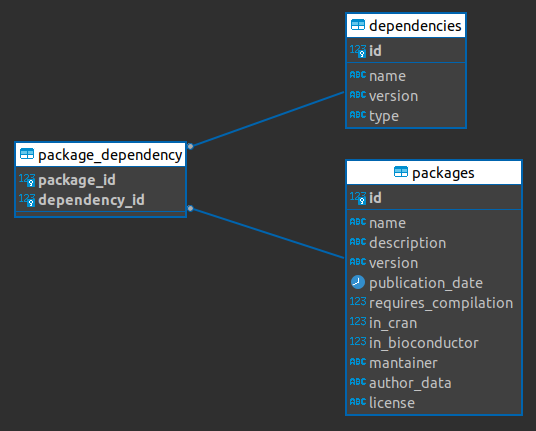

### MySQL

#### MySQL client installation

In principle it is not necessary to install the mysql client, but it will be useful for testing

In [ ]:
# !sudo apt install mysql-client

#### Docker installation

First of all we are going to install docker in the system, to carry out this process in an easier way, the install_docker.sh script has been implemented.
Run it if you consider it necessary. 

You will have to run it from the system console, since administrator privileges will be required and you will have to provide the password.

In [1]:
!cat install_docker.sh

#!/bin/bash

# Actualizar lista de paquetes y dependencias
sudo apt-get update

# Instalar dependencias necesarias
sudo apt-get install -y apt-transport-https ca-certificates curl gnupg lsb-release

# Descargar la clave GPG oficial de Docker
curl -fsSL https://download.docker.com/linux/ubuntu/gpg | sudo gpg --dearmor -o /usr/share/keyrings/docker-archive-keyring.gpg

# Añadir el repositorio oficial de Docker a las fuentes de apt
echo "deb [arch=amd64 signed-by=/usr/share/keyrings/docker-archive-keyring.gpg] https://download.docker.com/linux/ubuntu $(lsb_release -cs) stable" | sudo tee /etc/apt/sources.list.d/docker.list > /dev/null

# Actualizar lista de paquetes y dependencias con el nuevo repositorio
sudo apt-get update

# Instalar la última versión estable de Docker
sudo apt-get install -y docker-ce docker-ce-cli containerd.io

# Agregar el usuario actual al grupo docker para poder ejecutar Docker sin sudo
sudo usermod -aG docker $USER

# Reiniciar el servicio de Docker para que los

#### Create the database using Docker

The first step is to create a Docker container with an image of MySQL and configure it with a password to connect ourselves

In [1]:
# Decoment to execute
# !docker run --name olivia_mysql -e MYSQL_ROOT_PASSWORD=olivia -e MYSQL_DATABASE=r_network -p 3306:3306 -d mysql:latest

Unable to find image 'mysql:latest' locally
latest: Pulling from library/mysql

1adcd755: Pulling fs layer 
e353f7d2: Pulling fs layer 
6ece42ef: Pulling fs layer 
d9a7b88e: Pulling fs layer 
b5858b1d: Pulling fs layer 
d248d982: Pulling fs layer 
5e83312d: Pulling fs layer 
427259d9: Pulling fs layer 
8698a290: Pulling fs layer 
4781893e: Pulling fs layer 
Digest: sha256:8653a170e0b0df19ea95055267def2615fc53c62df529e3750817c1a886485f0
Status: Downloaded newer image for mysql:latest
95a6f74e62f7d9dcbd726c0eacada90afe3179d89305797d9a46d7e68ebc64fe


If we wanted to remove the container we can do it with

In [11]:
# Decoment to execute
# !docker rm -f olivia_mysql

olivia_mysql


We can see that the container is running

In [6]:
!docker ps

CONTAINER ID   IMAGE          COMMAND                  CREATED          STATUS          PORTS                                                  NAMES
95a6f74e62f7   mysql:latest   "docker-entrypoint.s…"   57 minutes ago   Up 57 minutes   0.0.0.0:3306->3306/tcp, :::3306->3306/tcp, 33060/tcp   olivia_mysql


Usually Docker's network is 172.17.0.1/16, as we are not clear about the IP that has been assigned to the container we obtain it through the next command

In [4]:
#docker inspect -f '{{range .NetworkSettings.Networks}}{{.IPAddress}}{{end}}' olivia_mysql

import subprocess

output = subprocess.check_output("docker inspect -f '{{range .NetworkSettings.Networks}}{{.IPAddress}}{{end}}' olivia_mysql", shell=True)
host_ip = output.decode().strip()
print(host_ip)


172.17.0.2


Now we have our database ready

In [6]:
!mysql -u root -polivia -h 172.17.0.2 -Bse "SHOW DATABASES;"

mysql: [Warning] Using a password on the command line interface can be insecure.
information_schema
mysql
performance_schema
r_network
sys


#### Implementation of the MySQL database model

First of all, we make sure that we have the necessary dependencies installed.

In [1]:
%pip install sqlalchemy
%pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 23.5 MB 9.6 MB/s eta 0:00:01
  Using cached protobuf-3.20.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 MB)
Note: you may need to restart the kernel to use updated packages.


Load the sqlalchemy libraries

In [2]:
from sqlalchemy import create_engine, Column, Integer, String, Text, Boolean, Date, ForeignKey
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship

We define the connection parameters to the database

In [5]:
db_connector =  "mysql+mysqlconnector"
db_user      =  "root"
db_passwd    =  "olivia"
db_host      =  host_ip
db_name      =  "r_network"

Create the database engine

In [7]:
engine = create_engine(db_connector + "://" + db_user + ":" + db_passwd + "@" + db_host + "/" + db_name)

Implementation of the database model

In [8]:
Base = declarative_base()

class Package_MySQL(Base):
    __tablename__ = 'packages'
    id = Column(Integer, primary_key=True, autoincrement=True)
    name = Column(String(255), nullable=False)
    description = Column(Text)
    version = Column(String(255), nullable=False)
    publication_date = Column(Date, nullable=False)
    requires_compilation = Column(Boolean, nullable=False)
    in_cran = Column(Boolean)
    in_bioconductor = Column(Boolean)
    mantainer = Column(String(255), nullable=False)
    author_data = Column(Text)
    license = Column(String(255), nullable=False)
    url = Column(String(255), nullable=False)
    dependencies = relationship('Dependency_MySQL', secondary='package_dependency')

class Dependency_MySQL(Base):
    __tablename__ = 'dependencies'
    id = Column(Integer, primary_key=True, autoincrement=True)
    name = Column(String(255), nullable=False)
    version = Column(String(255), nullable=False)
    type = Column(String(255), nullable=False)

class PackageDependency_MySQL(Base):
    __tablename__ = 'package_dependency'
    package_id = Column(Integer, ForeignKey('packages.id'), primary_key=True)
    dependency_id = Column(Integer, ForeignKey('dependencies.id'), primary_key=True)

Create the representation of the model (If you have already done it, do not do it again)

In [12]:
# Base.metadata.create_all(engine)

Delete the database

In [6]:
# Base.metadata.drop_all(engine)

Create a session

In [9]:
from sqlalchemy.orm import sessionmaker

In [14]:
# create session
Session = sessionmaker(bind=engine)
session = Session()

insert a package

In [15]:
# insert package
package = Package_MySQL(
    name="pakage_test", 
    description="lore ipsum dolor sit amet", 
    version="1.0.0", 
    publication_date="2023-01-01", 
    requires_compilation=True, 
    in_cran=True, 
    in_bioconductor=False, 
    mantainer="Fulanito de tal", 
    author_data="lore ipsum dolor sit amet", 
    license="license",
    url="http://url"

)
session.add(package)
session.commit()

# insert dependency
dependency = Dependency_MySQL(name="dependency_test", version="1.0.0", type="type")
session.add(dependency)
session.commit()

# insert package_dependency
package_dependency = PackageDependency_MySQL(package_id=package.id, dependency_id=dependency.id)
session.add(package_dependency)
session.commit()



Get database packages

In [16]:
# query package
package = session.query(Package_MySQL).filter(Package_MySQL.id == 1).first()

# query dependency
dependency = session.query(Dependency_MySQL).filter(Dependency_MySQL.id == 1).first()

# query package dependency
package_dependency = session.query(PackageDependency_MySQL).filter(PackageDependency_MySQL.package_id == 1).first()

# --------------------

print("Package name: ", package.name)
print("Package description: ", package.description)
print("Package version: ", package.version)
print("Package publication date: ", package.publication_date)
print("Package requires compilation: ", package.requires_compilation)
print("Package in cran: ", package.in_cran)
print("Package in bioconductor: ", package.in_bioconductor)
print("Package mantainer: ", package.mantainer)
print("Package author data: ", package.author_data)
print("Package license: ", package.license)
print("Package url: ", package.url)
print("Package dependencies: ", package.dependencies)


Package name:  pakage_test
Package description:  lore ipsum dolor sit amet
Package version:  1.0.0
Package publication date:  2023-01-01
Package requires compilation:  True
Package in cran:  True
Package in bioconductor:  False
Package mantainer:  Fulanito de tal
Package author data:  lore ipsum dolor sit amet
Package license:  license
Package url:  http://url
Package dependencies:  [<__main__.Dependency_MySQL object at 0x7f2faf2893d0>]


In [17]:
# Close the session
session.close()

# **2 - Definition of data structures**

This section shows an implementation of the classes necessary to interact with the data.

The representation of the dependency object is implemented in the Dependency class.

- It will be stored as a module in the path <code>./modules/Dependency.py</code>

In [18]:
class Dependency:

    # Class constructor
    def __init__(self):

        self.id = None
        self.name = None
        self.type = None
        self.version = None

    def create(self, name: str, type: str, version: str):

        self.name = name
        self.type = type
        self.version = version

    # String representation of the Dependency class
    def __str__(self):

        if self.version:
            return self.name + " (" + str(self.version) + ")" + " type: " + self.type
        else:
            return self.name + ", type: " + self.type

    # function to get the dependency from the database
    def build_from_db(self, session: Session):

        # If the dependency exists, initialize the dependency
        dependency_db = session.query(Dependency_MySQL).filter(Dependency_MySQL.id == self.id).first()
        if dependency_db:
            self.id = dependency_db.id
            self.name = dependency_db.name
            self.type = dependency_db.type
            self.version = dependency_db.version

    # function to save the dependency in the database
    def save_in_db(self, session: Session):

        # If the dependency does not have an id, insert it in the database
        if not self.id:

            d = Dependency_MySQL(name=self.name, version=self.version, type=self.type)
            session.add(d)
            session.commit()
            self.id = session.query(Dependency_MySQL).filter(Dependency_MySQL.name == self.name).first().id

        # If the dependency has an id, update it in the database
        else:
            self.update_in_db(session)

    # function to update the dependency in the database
    def update_in_db(self, session: Session):

        # Update the dependency in the database
        session.query(Dependency_MySQL).filter(Dependency_MySQL.id == self.id).update(
            {
                Dependency_MySQL.name: self.name,
                Dependency_MySQL.type: self.type,
                Dependency_MySQL.version: self.version
            }
        )
        session.commit()

    # function to print the data of the Dependency class

    def dump(self):
        return f'{self.type}:{self.name}:{self.version}'


The representation of the package object is implemented in the Package class.

- It will be stored as a module in the path <code>./modules/Package.py</code>

In [19]:
class Package:
 
    # Constructor
    def __init__(self):
  
        self.id = None
        self.name = None
        self.description = None
        self.version = None
        self.publication_date = None
        self.mantainer = None
        self.author_data = None
        self.dependencies : list[Dependency] = None
        self.license = None
        self.requires_compilation = None
        self.in_cran = True
        self.in_bioc = None
        self.url = None

    # Makes a representation of the object in a readable form
    def __str__(self):
        return self.name + " " + self.version

    # Prints a representation of the object in stdout
    def dump(self):

        mantainers_str = self.mantainer
        dependencies_str = "\n".join(f"  - {dep}" for dep in self.dependencies)

        package_str = f"""\
Name: {self.name}
Description:
{self.description or "None"}
Version: {self.version or "None"}
Publication date: {self.publication_date or "None"}
Mantainer: {mantainers_str or "None"}
Authors:
{self.author_data or "None"}
Dependencies:
{dependencies_str or "None"}
Requires compilation: {self.requires_compilation or "None"}
In CRAN: {self.in_cran or "None"}
In Bioconductor: {self.in_bioc or "None"}
Licenses:
{self.license or "None"}
Links:
{self.url or "None"}
"""
        print(package_str)

    # Build the object from the information in the database
    def build_from_db(self, session: Session) -> bool:

        # Get the package from the database
        package_db = session.query(Package_MySQL).filter(Package_MySQL.name == self.name).first()

        # If the package is not in the database, return False
        if package_db is None:
            return False
        
        # If the package is in the database, build the object
        self.id = package_db.id
        self.name = package_db.name
        self.description = package_db.description
        self.version = package_db.version
        self.publication_date = package_db.publication_date
        self.mantainer = package_db.mantainer
        self.author_data = package_db.author_data
        self.requires_compilation = package_db.requires_compilation
        self.in_cran = package_db.in_cran
        self.in_bioc = package_db.in_bioconductor
        self.license = package_db.license
        self.url = package_db.url

        # Get the dependencies from the database
        dependencies_db = session.query(Dependency_MySQL).filter(Dependency_MySQL.id == self.id).all()
        self.dependencies = [Dependency().create(dep.name, dep.type, dep.version) for dep in dependencies_db]    

        return True
    
    # Save to database
    def save_in_db(self, session: Session) -> bool:

        # Check if the package is already in the database, 
        if self.id is not None:
            # Update the package
            self.update_in_db(session)

        else:
            # Create the package in the database
            package = Package_MySQL()
            package.name = self.name
            package.description = self.description
            package.version = self.version
            package.publication_date = self.publication_date
            package.mantainer = self.mantainer
            package.author_data = self.author_data
            package.requires_compilation = self.requires_compilation
            package.in_cran = self.in_cran
            package.in_bioconductor = self.in_bioc
            package.license = self.license
            package.url = self.url
            session.add(package)
            session.commit()

            # Save the dependencies in the database
            self.id = session.query(Package_MySQL).filter(Package_MySQL.name == self.name).first().id
            for dependency in self.dependencies:
                dependency.save_in_db(session)      
            
            return True

    # Update the package in the database
    def update_in_db(self, session: Session) -> bool:

        # Check if the package is in the database
        # ---------------------------------------
        if self.id is None:
            return False

        # Update the package in the database
        # ----------------------------------
        package_db = session.query(Package_MySQL).filter(Package_MySQL.id == self.id).first()

        package_db.name = self.name
        package_db.description = self.description
        package_db.version = self.version
        package_db.publication_date = self.publication_date
        package_db.mantainer = self.mantainer
        package_db.authors_data = self.author_data
        package_db.requires_compilation = self.requires_compilation
        package_db.in_cran = self.in_cran
        package_db.in_bioc = self.in_bioc
        package_db.license = self.license
        package_db.url = self.url
        session.commit()

        # Update the dependencies in the database
        for dependency in self.dependencies:
            dependency.update_in_db(session)

        return True

# **3 - Testing**

Create a Dependency object

In [32]:
# Build a dependency object example
d = Dependency()
d.name = "R"
d.version = "4.0.3"
d.type = "DEP"
d.dump()

'DEP:R:4.0.3'

Create a Package object

In [33]:
package = Package()
package.name = "ggplot2"
package.description = "ggplot2 is a plotting system for R, based on the grammar of graphics, which tries to take the good parts of base and lattice graphics and none of the bad parts. It takes care of many of the fiddly details that make plotting a hassle (like drawing legends) as well as providing a powerful model of graphics that makes it easy to produce complex multi-layered graphics."
package.version = "3.3.2"
package.publication_date = "2016-05-01"
package.mantainer = "Hadley Wickham"
package.author_data = "Hadley Wickham, Winston Chang, Lionel Henry, Thomas Lin Pedersen, Kohske Takahashi, Claus Wilke, Kara Woo, Hiroaki Yutani"
package.requires_compilation = False
package.in_cran = True
package.in_bioc = False
package.license = "GPL (>= 2)"
package.dependencies = [d]
package.url = "https://ggplot2.tidyverse.org/"
package.dump()

Name: ggplot2
Description:
ggplot2 is a plotting system for R, based on the grammar of graphics, which tries to take the good parts of base and lattice graphics and none of the bad parts. It takes care of many of the fiddly details that make plotting a hassle (like drawing legends) as well as providing a powerful model of graphics that makes it easy to produce complex multi-layered graphics.
Version: 3.3.2
Publication date: 2016-05-01
Mantainer: Hadley Wickham
Authors:
Hadley Wickham, Winston Chang, Lionel Henry, Thomas Lin Pedersen, Kohske Takahashi, Claus Wilke, Kara Woo, Hiroaki Yutani
Dependencies:
  - R (4.0.3) type: DEP
Requires compilation: None
In CRAN: True
In Bioconductor: None
Licenses:
GPL (>= 2)
Links:
https://ggplot2.tidyverse.org/



Insert the package into the database

In [34]:
# Create a db session
Session = sessionmaker(bind=engine)
session = Session()

The function returns True if the package has been inserted and False if it already exists in the database.

In [35]:
# Save the package in the database
package.save_in_db(session)

True

Get a package from the database

In [36]:
# Create a package
package_test = Package()
package_test.name = "ggplot2"
session = Session()
package_test.build_from_db(session)

# Print the package
package_test.dump()

Name: ggplot2
Description:
ggplot2 is a plotting system for R, based on the grammar of graphics, which tries to take the good parts of base and lattice graphics and none of the bad parts. It takes care of many of the fiddly details that make plotting a hassle (like drawing legends) as well as providing a powerful model of graphics that makes it easy to produce complex multi-layered graphics.
Version: 3.3.2
Publication date: 2016-05-01
Mantainer: Hadley Wickham
Authors:
Hadley Wickham, Winston Chang, Lionel Henry, Thomas Lin Pedersen, Kohske Takahashi, Claus Wilke, Kara Woo, Hiroaki Yutani
Dependencies:
  - None
Requires compilation: None
In CRAN: True
In Bioconductor: None
Licenses:
GPL (>= 2)
Links:
https://ggplot2.tidyverse.org/

